# Goal
- tf 모델 학습 리마인드
    - model 학습시 설정 튜닝
 


In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

2022-01-03 15:56:34.163896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 15:56:34.173032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 15:56:34.173468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn

from tensorflow import keras
from tensorflow.keras import layers, callbacks
import tensorflow_hub as hub

import seaborn as sns
import matplotlib.pyplot as plt

import pathlib
import PIL
import datetime

In [3]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

In [4]:
print("Tensorflow version " + tf.__version__)

# Detect and init the TPU
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Tensorflow version 2.6.0
Number of accelerators:  1


In [ ]:
'''ref
def dense_block(units, activation, dropout_rate, l1=None, l2=None):
    def make(inputs):
        x = layers.Dense(units)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Dropout(dropout_rate)(x)
        return x
    return make

with strategy.scope():
    # Wide Network
    wide = keras.experimental.LinearModel()

    # Deep Network
    inputs = keras.Input(shape=[28])
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(inputs)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    outputs = layers.Dense(1)(x)
    deep = keras.Model(inputs=inputs, outputs=outputs)
    
    # Wide and Deep Network
    wide_and_deep = keras.experimental.WideDeepModel(
        linear_model=wide,
        dnn_model=deep,
        activation='sigmoid',
    )

wide_and_deep.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['AUC', 'binary_accuracy'],
    experimental_steps_per_execution=steps_per_execution,
)
'''

데이터셋 전처리
- 이미지 사이즈
-

모델
학습
결과

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn

from tensorflow import keras
from tensorflow.keras import layers, callbacks
import tensorflow as tf


import seaborn as sns
import matplotlib.pyplot as plt

import pathlib
import PIL

In [ ]:
#! unzip intel-image-classification.zip

In [6]:
train_dir = pathlib.Path('./input/intel-image-classification/seg_train/seg_train')
test_dir = pathlib.Path('./input/intel-image-classification/seg_test/seg_test')
pred_dir = pathlib.Path('./input/intel-image-classification/seg_pred/seg_pred')

data_info = pd.DataFrame()
for sub_dir in [train_dir, test_dir]:
    total = len(list(sub_dir.glob('./*/*.jpg')))
    print(f'{sub_dir.name} 총 이미지 수: {total}')
    for cat in sub_dir.glob('./*'):
        doc = {'kind':sub_dir.name}
        cat_total = len(list(cat.glob('./*.jpg')))
        doc.update({'category':cat.name,
                    'num_images': cat_total})
        print(f'- {cat.name} category 이미지 수: {cat_total}')
        data_info = data_info.append(doc,ignore_index=True)
    print()
        

seg_train 총 이미지 수: 14034
- buildings category 이미지 수: 2191
- forest category 이미지 수: 2271
- glacier category 이미지 수: 2404
- mountain category 이미지 수: 2512
- sea category 이미지 수: 2274
- street category 이미지 수: 2382

seg_test 총 이미지 수: 3000
- buildings category 이미지 수: 437
- forest category 이미지 수: 474
- glacier category 이미지 수: 553
- mountain category 이미지 수: 525
- sea category 이미지 수: 510
- street category 이미지 수: 501



In [10]:
data_info

,kind,category,num_images
0,seg_train,buildings,2191.0
1,seg_train,forest,2271.0
2,seg_train,glacier,2404.0
3,seg_train,mountain,2512.0
4,seg_train,sea,2274.0
5,seg_train,street,2382.0
6,seg_test,buildings,437.0
7,seg_test,forest,474.0
8,seg_test,glacier,553.0
9,seg_test,mountain,525.0


Text(0.5, 1.0, 'A number of images for each category')

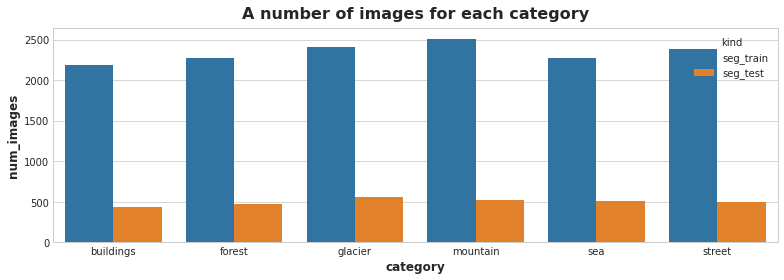

In [11]:
sns.barplot(x='category', y='num_images', hue='kind', data=data_info)
plt.title('A number of images for each category')

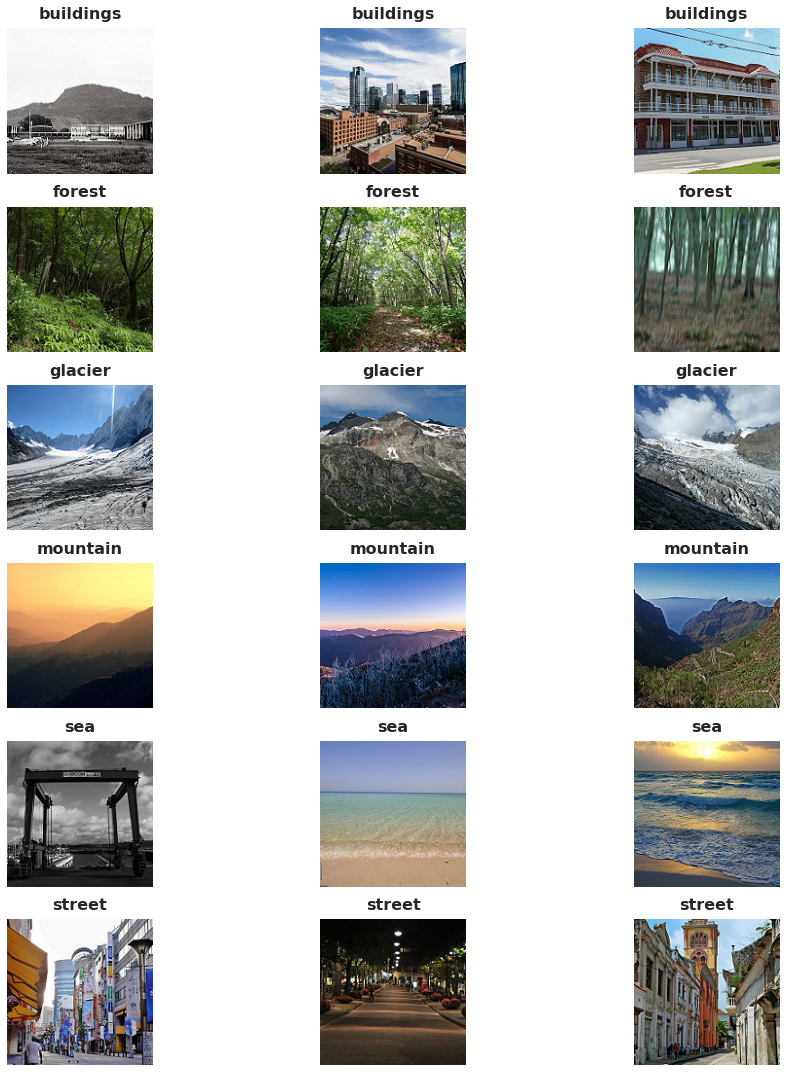

In [12]:
fig, ax = plt.subplots(ncols=3, nrows=6, figsize=(15,15))
for sub_dir in [train_dir]:
    for i, cat in enumerate(sub_dir.glob('./*')):
            for j, image in enumerate(list(cat.glob('./*.jpg'))[:3]):
                img = plt.imread(image)
                ax[i][j].imshow(img)
                ax[i][j].axis('off')
                ax[i][j].set_title(cat.name)
    print()

# Load data

In [7]:
batch_size = 32
img_height = 224
img_width = 224

In [8]:
train_ds = keras.utils.image_dataset_from_directory(train_dir, 
                                                    image_size=(img_height, img_width),
                                                    #validation_split=0.2, 
                                                    #subset='training', 
                                                    seed=1)


Found 14034 files belonging to 6 classes.


2022-01-03 15:56:49.497721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 15:56:49.498170: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 15:56:49.498539: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 15:56:49.787657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 15:56:49.788046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

In [9]:
val_ds = keras.utils.image_dataset_from_directory(test_dir, 
                                                  image_size=(img_height, img_width),
                                                  #subset='validation', 
                                                  seed=1)

pred_ds = keras.utils.image_dataset_from_directory(pred_dir,
                                                   image_size=(img_height, img_width),
                                                   labels=None)


Found 3000 files belonging to 6 classes.
Found 7301 files belonging to 1 classes.


In [16]:
next(iter(pred_ds)).shape

2022-01-03 09:41:01.662015: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


TensorShape([32, 256, 256, 3])

In [10]:
class_names = train_ds.class_names
num_classes = len(train_ds.class_names)

Images are shown using above train_ds/test_ds

In [ ]:
'''
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
'''

In [11]:
# 만들어진 ds에 대해 iter가능
# You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.
input_shape = None
for img_batch, label_batch in train_ds:
    input_shape = img_batch.shape
    print(img_batch.shape)    # 이미지 batch
    print(label_batch.shape)  #이미지 batch에 대한 레이블
    break

(32, 224, 224, 3)
(32,)


2022-01-03 15:57:01.219660: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


### **Configure the dataset for performance** <br>
Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

**Dataset.cache** keeps the images in memory after they're loaded off disk during the first epoch. <br>
This will ensure the dataset does not become a bottleneck while training your model. <br>
If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache. <br><br>
**Dataset.prefetch** overlaps data preprocessing and model execution while training. <br>


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
# 이미지 rescaling..좋다.
normalization_layer = layers.Rescaling(scale=1./255)
norm_ds = train_ds.map(lambda x,y: (normalization_layer(x),y))
norm_img_batch ,label_batch = next(iter(norm_ds))
first_image = norm_img_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99667406


# Model

In [21]:
# input_shape[1:] = batch 사이즈 빼고
# num_classes = len(train_ds.class_names) # class integer라서 마지막 dense 함수에서 사용

model = keras.Sequential([layers.Rescaling(scale=1./255, input_shape=input_shape[1:]), 
                          layers.Conv2D(16,3, padding='same', activation='relu'), 
                          layers.MaxPooling2D(),
                          layers.Conv2D(32,3, padding='same', activation='relu'), 
                          layers.MaxPooling2D(),
                          layers.Conv2D(64,3, padding='same', activation='relu'), 
                          layers.MaxPooling2D(), 
                          layers.Flatten(), 
                          layers.Dense(128, activation='relu'), 
                          layers.Dense(num_classes)])

In [22]:
'''

keras.losses.SparseCategoricalCrossentropy: 레이블이 integer로 주어졌을 때 사용
CategoricalCrossentropy: 레이블이 원핫인코딩 되어있을 때

Computes the crossentropy loss between the labels and predictions.

Use this crossentropy loss function when there are two or more label classes.
We expect labels to be provided as integers. If you want to provide labels
using `one-hot` representation, please use `CategoricalCrossentropy` loss.
There should be `# classes` floating point values per feature for `y_pred`
and a single floating point value per feature for `y_true`.

from_logits: Whether `y_pred` is expected to be a logits tensor. By
    default, we assume that `y_pred` encodes a probability distribution.

'''

model.compile(optimizer='adam', 
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

es = keras.callbacks.EarlyStopping(min_delta=0.001, 
                                   patience=3, 
                                   verbose=0, 
                                   restore_best_weights=True)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0

In [23]:
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    callbacks=[es], 
                    epochs=15,)

Epoch 1/15


2022-01-03 09:43:21.470262: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204
2022-01-03 09:43:22.170844: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-03 09:43:22.704089: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


439/439 [==============================] - 8s 14ms/step - loss: 0.9893 - accuracy: 0.6288 - val_loss: 0.7349 - val_accuracy: 0.7330
Epoch 2/15
439/439 [==============================] - 5s 12ms/step - loss: 0.6341 - accuracy: 0.7649 - val_loss: 0.5962 - val_accuracy: 0.7850
Epoch 3/15
439/439 [==============================] - 5s 12ms/step - loss: 0.4445 - accuracy: 0.8385 - val_loss: 0.6233 - val_accuracy: 0.7863
Epoch 4/15
439/439 [==============================] - 5s 12ms/step - loss: 0.2724 - accuracy: 0.9042 - val_loss: 0.7098 - val_accuracy: 0.7863
Epoch 5/15
439/439 [==============================] - 5s 12ms/step - loss: 0.1412 - accuracy: 0.9516 - val_loss: 0.7855 - val_accuracy: 0.7893


<AxesSubplot:title={'center':'Accuracy'}>

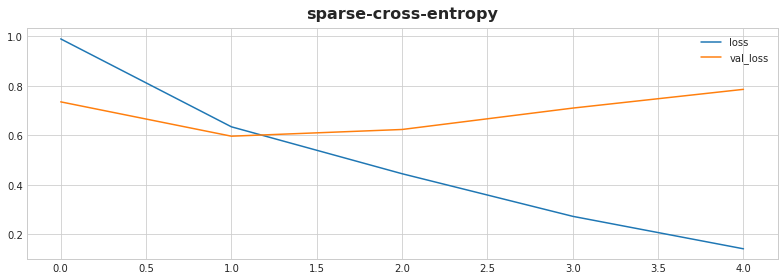

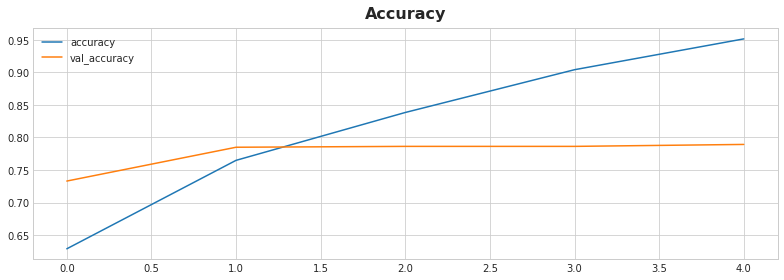

In [24]:
# 하다 멈춰서 다시 돌림
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="sparse-cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [25]:
history_df

,loss,accuracy,val_loss,val_accuracy
0,0.989349,0.628830,0.734945,0.733000
1,0.634103,0.764857,0.596215,0.785000
2,0.444528,0.838464,0.623296,0.786333
3,0.272352,0.904233,0.709777,0.786333
4,0.141169,0.951617,0.785496,0.789333


Over epoch=3 it looks overfitted. To improve model's accuracy use
- Dropout
- Data augmentation (just ref for next)

In [13]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=input_shape[1:]),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


In [32]:
# input_shape[1:] = batch 사이즈 빼고
# num_classes = len(train_ds.class_names) # class integer라서 마지막 dense 함수에서 사용
with strategy.scope():
    model = keras.Sequential([data_augmentation, 
                              layers.Rescaling(scale=1./255, input_shape=input_shape[1:]), 
                              layers.Conv2D(16,3, padding='same', activation='relu'), 
                              layers.MaxPooling2D(),
                              layers.Conv2D(32,3, padding='same', activation='relu'), 
                              layers.MaxPooling2D(),
                              layers.Conv2D(64,3, padding='same', activation='relu'), 
                              layers.MaxPooling2D(),
                              layers.Dropout(0.2),
                              layers.Flatten(),
                              layers.Dense(128, activation='relu'), 
                              layers.Dense(num_classes)])


model.compile(optimizer='adam', 
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

es = keras.callbacks.EarlyStopping(min_delta=0.001, 
                                   patience=10, 
                                   verbose=0, 
                                   restore_best_weights=True)

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)       

### dropout 1개 추가

Epoch 1/15
439/439 [==============================] - 6s 12ms/step - loss: 1.0006 - accuracy: 0.6300 - val_loss: 0.7713 - val_accuracy: 0.7113
Epoch 2/15
439/439 [==============================] - 5s 12ms/step - loss: 0.6536 - accuracy: 0.7592 - val_loss: 0.6364 - val_accuracy: 0.7647
Epoch 3/15
439/439 [==============================] - 5s 12ms/step - loss: 0.4924 - accuracy: 0.8246 - val_loss: 0.5930 - val_accuracy: 0.7927
Epoch 4/15
439/439 [==============================] - 5s 12ms/step - loss: 0.3325 - accuracy: 0.8822 - val_loss: 0.6576 - val_accuracy: 0.7833
Epoch 5/15
439/439 [==============================] - 5s 12ms/step - loss: 0.2064 - accuracy: 0.9277 - val_loss: 0.8063 - val_accuracy: 0.7640
Epoch 6/15
439/439 [==============================] - 5s 12ms/step - loss: 0.1223 - accuracy: 0.9590 - val_loss: 0.8037 - val_accuracy: 0.7927
Epoch 7/15
439/439 [==============================] - 5s 12ms/step - loss: 0.0906 - accuracy: 0.9724 - val_loss: 0.9697 - val_accuracy: 0.7677

<AxesSubplot:title={'center':'Accuracy'}>

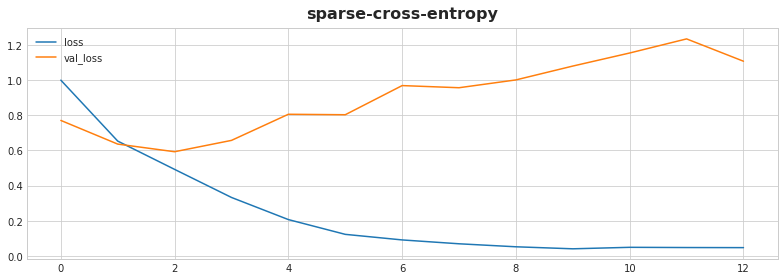

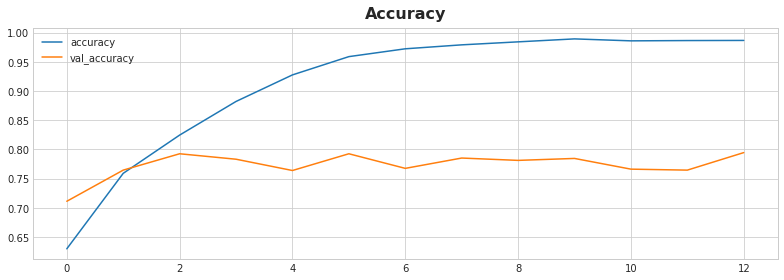

In [29]:
history2 = model.fit(train_ds, 
                    validation_data=val_ds, 
                    callbacks=[es], 
                    epochs=15,)

history_df2 = pd.DataFrame(history2.history)
history_df2.loc[:, ['loss', 'val_loss']].plot(title="sparse-cross-entropy")
history_df2.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

### data augmentation 추가
- acc가 좀 올라가네.

Epoch 1/15
439/439 [==============================] - 7s 14ms/step - loss: 1.0354 - accuracy: 0.6052 - val_loss: 0.8828 - val_accuracy: 0.6520
Epoch 2/15
439/439 [==============================] - 6s 14ms/step - loss: 0.8085 - accuracy: 0.7014 - val_loss: 0.7245 - val_accuracy: 0.7380
Epoch 3/15
439/439 [==============================] - 6s 14ms/step - loss: 0.7164 - accuracy: 0.7331 - val_loss: 0.7333 - val_accuracy: 0.7317
Epoch 4/15
439/439 [==============================] - 6s 14ms/step - loss: 0.6536 - accuracy: 0.7622 - val_loss: 0.5855 - val_accuracy: 0.7927
Epoch 5/15
439/439 [==============================] - 6s 14ms/step - loss: 0.6028 - accuracy: 0.7820 - val_loss: 0.5462 - val_accuracy: 0.8063
Epoch 6/15
439/439 [==============================] - 6s 14ms/step - loss: 0.5474 - accuracy: 0.8047 - val_loss: 0.5327 - val_accuracy: 0.8173
Epoch 7/15
439/439 [==============================] - 6s 14ms/step - loss: 0.5174 - accuracy: 0.8142 - val_loss: 0.5412 - val_accuracy: 0.8083

<AxesSubplot:title={'center':'Accuracy'}>

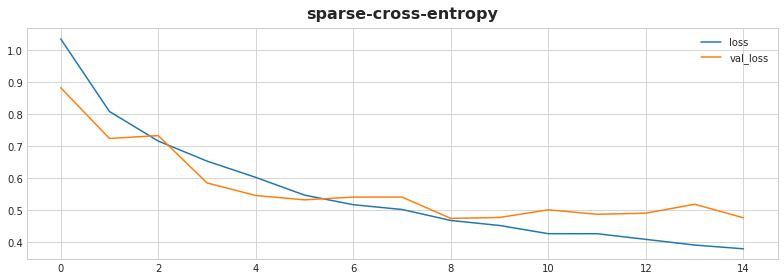

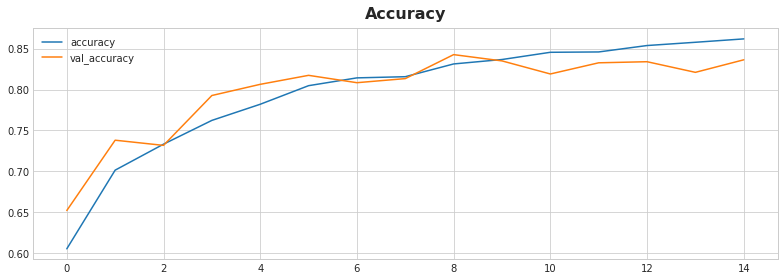

In [33]:
history3 = model.fit(train_ds, 
                    validation_data=val_ds, 
                    callbacks=[es], 
                    epochs=15,)

history_df = pd.DataFrame(history3.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="sparse-cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

## Fine-tuning with trained model
- 이미지 rescaling 하고 안 하고 차이가 큼 (+- 0.1 차이)

In [23]:
import tensorflow_hub as hub
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
# efficient_b6 = "https://tfhub.dev/tensorflow/efficientnet/b6/classification/1"
#feature_extractor_model = mobilenet_v2
feature_extractor_model = inception_v3

# feature_extractor_model = efficient_b6

In [24]:
with strategy.scope(): # gpu가 1개라..지금은 의미가 없다
    feature_extractor_layer  = hub.KerasLayer(feature_extractor_model, 
                                              #input_shape=input_shape[1:], 
                                              trainable=False)

    model = keras.Sequential([layers.Rescaling(scale=1./255, input_shape=input_shape[1:]),
                              feature_extractor_layer, 
                              layers.Dense(num_classes)])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer_3 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 12294     
Total params: 21,815,078
Trainable params: 12,294
Non-trainable params: 21,802,784
_________________________________________________________________


In [25]:
for image_batch, label_batch in train_ds:
    feature_batch = feature_extractor_layer(image_batch)
    print(feature_batch.shape)
    #print(feature_batch)
    break

(32, 2048)


In [82]:
feature_extractor_layer.

[]

In [26]:
model.compile(optimizer='adam', 
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

cmt = 'inceptionv3'
log_dir = f'./log/intel-image-classification/{cmt}' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

es = keras.callbacks.EarlyStopping(min_delta=0.001, 
                                   patience=10, 
                                   verbose=0, 
                                   restore_best_weights=True)

tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) # Enable histogram computation for every epoch.)

history4 = model.fit(train_ds, 
          validation_data=val_ds, 
          callbacks=[es, tensorboard], 
          epochs=20)

2022-01-03 16:11:09.159517: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-03 16:11:09.159551: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-03 16:11:09.450637: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-03 16:11:09.450975: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed


Epoch 1/20
  1/439 [..............................] - ETA: 17:56 - loss: 1.8492 - accuracy: 0.2812

2022-01-03 16:11:12.612314: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-03 16:11:12.612361: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  3/439 [..............................] - ETA: 5:53 - loss: 1.7185 - accuracy: 0.3021

2022-01-03 16:11:13.424635: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-03 16:11:13.426605: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed
2022-01-03 16:11:13.469592: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 592 callback api events and 593 activity events. 
2022-01-03 16:11:13.481069: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-03 16:11:13.495883: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./log/intel-image-classification/inceptionv320220103-161109/train/plugins/profile/2022_01_03_16_11_13

2022-01-03 16:11:13.507870: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./log/intel-image-classification/inceptionv320220103-161109/train/plugins/profile/2022_01_03_16_11_13/fc661bd70d7b.trace.json.gz
2022-01-03 1

439/439 [==============================] - 17s 32ms/step - loss: 0.3286 - accuracy: 0.8804 - val_loss: 0.2624 - val_accuracy: 0.9063
Epoch 2/20
439/439 [==============================] - 12s 26ms/step - loss: 0.2351 - accuracy: 0.9139 - val_loss: 0.2514 - val_accuracy: 0.9083
Epoch 3/20
439/439 [==============================] - 12s 27ms/step - loss: 0.2089 - accuracy: 0.9247 - val_loss: 0.2611 - val_accuracy: 0.9043
Epoch 4/20
439/439 [==============================] - 12s 26ms/step - loss: 0.1971 - accuracy: 0.9258 - val_loss: 0.2509 - val_accuracy: 0.9010
Epoch 5/20
439/439 [==============================] - 12s 26ms/step - loss: 0.1768 - accuracy: 0.9347 - val_loss: 0.2584 - val_accuracy: 0.9067
Epoch 6/20
439/439 [==============================] - 12s 26ms/step - loss: 0.1748 - accuracy: 0.9363 - val_loss: 0.2422 - val_accuracy: 0.9097
Epoch 7/20
439/439 [==============================] - 12s 26ms/step - loss: 0.1654 - accuracy: 0.9380 - val_loss: 0.2941 - val_accuracy: 0.8950
Epo

In [65]:
#%load_ext tensorboard
#%tensorboard --logdir ./log/intel-image-classification/

# keras.appliications를 이용해 fine-tuning
- Efficient-Net 사용

In [60]:
# Create the base model from the pre-trained model MobileNet V2
# keras.applications에서 불러오는 pre-trained model

base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape[1:],
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [29]:
for image_batch, label_batch in train_ds:
    feature_batch = base_model(image_batch)
    print(feature_batch.shape)
    
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    print(feature_batch_average.shape)
    #print(feature_batch)
    break

(32, 7, 7, 1280)
(32, 1280)


In [30]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_6 (Rescaling)         (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_6[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
_____________________________________________________________________________________

## augmentation 레이어

In [36]:
img_augmentation =  keras.Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

### pre-trained model top 미포함

In [61]:
inputs = keras.Input(shape=input_shape[1:])
#x = img_augmentation(inputs)
x = layers.Rescaling(1./127.5, offset=-1)(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(num_classes)(x)
model = keras.Model(inputs, outputs)

### pre-trained model top 포함

In [27]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape[1:],
                                               include_top=True,
                                               weights='imagenet')
for image_batch, label_batch in train_ds:
    feature_batch = base_model(image_batch)
    print(feature_batch.shape)
    #print(feature_batch)
    break
    
inputs = keras.Input(shape=input_shape[1:])
x = layers.Rescaling(1./127.5, offset=-1)(inputs)
x = base_model(x, training=False)
outputs = layers.Dense(num_classes)(x)
model = keras.Model(inputs, outputs)

(32, 1000)


In [50]:
base_learning_rate = 0.01
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
cmt = 'b0_batchnorm_and_aurment_layer'
log_dir =f'./log/intel-image-classification/{cmt}/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) # Enable histogram computation for every epoch.)

history4 = model.fit(train_ds, 
          validation_data=val_ds, 
          callbacks=[es, tensorboard], 
          epochs=20)

2022-01-03 17:16:28.367465: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-03 17:16:28.367488: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-03 17:16:28.662881: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-03 17:16:28.663044: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed


Epoch 1/20
  1/439 [..............................] - ETA: 17:12 - loss: 1.8023 - accuracy: 0.1250

2022-01-03 17:16:31.820456: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-03 17:16:31.820493: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/439 [..............................] - ETA: 7:45 - loss: 1.6834 - accuracy: 0.2344 

2022-01-03 17:16:32.445159: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-03 17:16:32.446667: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed
2022-01-03 17:16:32.512336: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 536 callback api events and 536 activity events. 
2022-01-03 17:16:32.522600: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-03 17:16:32.891104: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./log/intel-image-classification/b0_batchnorm_and_aurment_layer/20220103-171628/train/plugins/profile/2022_01_03_17_16_32

2022-01-03 17:16:32.901762: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./log/intel-image-classification/b0_batchnorm_and_aurment_layer/20220103-171628/train/plugins/profile/2022_01_03_17_16_32

  9/439 [..............................] - ETA: 1:47 - loss: 1.7957 - accuracy: 0.2674

2022-01-03 17:16:32.942221: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./log/intel-image-classification/b0_batchnorm_and_aurment_layer/20220103-171628/train/plugins/profile/2022_01_03_17_16_32
Dumped tool data for xplane.pb to ./log/intel-image-classification/b0_batchnorm_and_aurment_layer/20220103-171628/train/plugins/profile/2022_01_03_17_16_32/fc661bd70d7b.xplane.pb
Dumped tool data for overview_page.pb to ./log/intel-image-classification/b0_batchnorm_and_aurment_layer/20220103-171628/train/plugins/profile/2022_01_03_17_16_32/fc661bd70d7b.overview_page.pb
Dumped tool data for input_pipeline.pb to ./log/intel-image-classification/b0_batchnorm_and_aurment_layer/20220103-171628/train/plugins/profile/2022_01_03_17_16_32/fc661bd70d7b.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to ./log/intel-image-classification/b0_batchnorm_and_aurment_layer/20220103-171628/train/plugins/profile/2022_01_03_17_16_32/fc661bd70d7b.tensorflow_stats.pb
Du

439/439 [==============================] - 18s 36ms/step - loss: 1.3985 - accuracy: 0.4453 - val_loss: 1.6813 - val_accuracy: 0.2350
Epoch 2/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2440 - accuracy: 0.5158 - val_loss: 1.1780 - val_accuracy: 0.5460
Epoch 3/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1904 - accuracy: 0.5406 - val_loss: 1.1017 - val_accuracy: 0.6007
Epoch 4/20
439/439 [==============================] - 13s 29ms/step - loss: 1.1789 - accuracy: 0.5470 - val_loss: 1.0972 - val_accuracy: 0.5823
Epoch 5/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1572 - accuracy: 0.5580 - val_loss: 1.0755 - val_accuracy: 0.5867
Epoch 6/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1451 - accuracy: 0.5590 - val_loss: 1.0648 - val_accuracy: 0.6103
Epoch 7/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1441 - accuracy: 0.5562 - val_loss: 1.0766 - val_accuracy: 0.5830
Epo

## fine-tune
- base model 레이어 일부만 학습. 
- 20층 학습은 바로 오버피팅
- 1층은 약간 성능 올라감

In [64]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-3:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    #optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    base_learning_rate = 1e-2
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])


unfreeze_model(model)
cmt = 'b0_unfreeze_model'
log_dir =f'./log/intel-image-classification/{cmt}/lr_1e-23layer_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) # Enable histogram computation for every epoch.)

history4 = model.fit(train_ds, 
          validation_data=val_ds, 
          callbacks=[es, tensorboard], 
          epochs=50)

2022-01-04 03:09:12.291784: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-04 03:09:12.291806: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-04 03:09:12.588357: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-04 03:09:12.588546: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed


Epoch 1/50
  1/439 [..............................] - ETA: 17:17 - loss: 1.1606 - accuracy: 0.4688

2022-01-04 03:09:15.167747: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-04 03:09:15.167781: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  6/439 [..............................] - ETA: 1:19 - loss: 1.0486 - accuracy: 0.5729

2022-01-04 03:09:15.782543: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-04 03:09:15.783521: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed
2022-01-04 03:09:15.821399: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 536 callback api events and 536 activity events. 
2022-01-04 03:09:15.829536: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-04 03:09:15.839154: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./log/intel-image-classification/b0_unfreeze_model/lr_5e-33layer_20220104-030912/train/plugins/profile/2022_01_04_03_09_15

2022-01-04 03:09:15.847428: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./log/intel-image-classification/b0_unfreeze_model/lr_5e-33layer_20220104-030912/train/plugins/profile/2022_01_04_03_09_

439/439 [==============================] - 16s 31ms/step - loss: 1.1295 - accuracy: 0.5684 - val_loss: 1.1127 - val_accuracy: 0.5723
Epoch 2/50
439/439 [==============================] - 12s 28ms/step - loss: 1.1081 - accuracy: 0.5799 - val_loss: 1.0396 - val_accuracy: 0.6207
Epoch 3/50
439/439 [==============================] - 12s 28ms/step - loss: 1.1248 - accuracy: 0.5688 - val_loss: 1.0358 - val_accuracy: 0.6070
Epoch 4/50
439/439 [==============================] - 12s 28ms/step - loss: 1.1145 - accuracy: 0.5750 - val_loss: 1.0436 - val_accuracy: 0.5997
Epoch 5/50
439/439 [==============================] - 12s 28ms/step - loss: 1.1013 - accuracy: 0.5803 - val_loss: 1.0501 - val_accuracy: 0.6007
Epoch 6/50
439/439 [==============================] - 12s 28ms/step - loss: 1.1264 - accuracy: 0.5740 - val_loss: 1.0483 - val_accuracy: 0.6140
Epoch 7/50
439/439 [==============================] - 13s 29ms/step - loss: 1.1037 - accuracy: 0.5799 - val_loss: 1.0586 - val_accuracy: 0.5893
Epo

# Predict
- 이미지 label 확인

In [39]:
class_names = np.array(class_names)
for image_batch in pred_ds:
    predicted_batch = model.predict(image_batch)
    predicted_id = tf.math.argmax(predicted_batch, axis=-1)
    print(predicted_id)
    predicted_label_batch = class_names[predicted_id]
    print(predicted_label_batch)
    break

tf.Tensor([3 2 0 2 1 3 5 2 5 5 5 2 3 4 3 5 4 0 3 3 2 2 2 5 2 5 1 2 1 5 4 4], shape=(32,), dtype=int64)
['mountain' 'glacier' 'buildings' 'glacier' 'forest' 'mountain' 'street'
 'glacier' 'street' 'street' 'street' 'glacier' 'mountain' 'sea'
 'mountain' 'street' 'sea' 'buildings' 'mountain' 'mountain' 'glacier'
 'glacier' 'glacier' 'street' 'glacier' 'street' 'forest' 'glacier'
 'forest' 'street' 'sea' 'sea']


# Export and reload the model
- 참조

In [ ]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

In [ ]:
reloaded = tf.keras.models.load_model(export_path)
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)
abs(reloaded_result_batch - result_batch).max()

reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

출력

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(reloaded_predicted_label_batch[n].title())
    plt.axis('off')
_ = plt.suptitle("Model predictions")

In [ ]:
'''
https://www.tensorflow.org/guide/distributed_training?hl=ko

위 예에서는 MirroredStrategy를 사용했기 때문에, 
하나의 장비가 다중 GPU를 가진 경우에 사용할 수 있습니다. 
strategy.scope()로 분산 처리할 부분을 코드에 지정할 수 있습니다. 
이 범위(scope) 안에서 모델을 만들면, 일반적인 변수가 아니라 미러링된 변수가 만들어집니다. 
이 범위 안에서 컴파일을 한다는 것은 작성자가 이 전략을 사용하여 모델을 훈련하려고 한다는 의미입니다. 
이렇게 구성하고 나서, 일반적으로 실행하는 것처럼 모델의 fit 함수를 호출합니다. 
MirroredStrategy가 모델의 훈련을 사용 가능한 GPU들로 복제하고, 
그래디언트들을 수집하는 것 등을 알아서 처리합니다.
'''
with strategy.scope():
    # 여기서 model 정의
    pass

## inceptionV3 나 mobileNet <br>
- inceptionV3 나 mobileNet을 pre-trained model로 사용했을 때 이들은 뒤에 붙이 레이어들의 하이퍼파라미터를 
약간 조정하면서 테스트했을 때 0.89~0.91 사이의 acc를 얻었다. 
- val_acc는 처음부터 거의 변화없거나 살짝 올라가는 모양새, train_val은 조금씩 계속 올라감.
<br>


## efficientNetB0, B7
- 위의 인셉션이나 모바일넷과 같이 pretrained-model에 pooling과 dense 정도만 붙였는데 acc는 잘 나와봤자 0.4 미만. 왜죠??
- 네트워크가 위의 네트워크보다 이미지의 부분부분을 더 자세히 보기 때문인가?
- 이미지 해상도는 224정도이고...그래서 처음엔 B7쓰다 B0로 바꿈. 그래도 학습은 영..
- pooling 뒤에 batchnorm 레이어 넣으니까 val_acc 0.6까지 올라감... 그래프도 안정적..
- augmentation_layer 적용했을 때 val_acc 가 batchnorm만 적용했을 때보다 떨어짐.
- 부분적으로 base_model 레이어를 unfreeze (20레이어)했더니 오버피팅 바로 옴.. train_acc는 오르는데 val_acc는 0.17* 대...
- 케라스 doc 참조: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
  - 문서에 의하면 적은 데이터셋과 낮은 해상도로는 efficientNet에서 오버피팅이 일어날 수 밖에 없다고 적혀있다.
  - 학습도 굉장히 천천히 된다고..
  
<br><br>
Note: the accuracy will increase very slowly and may overfit.<br>
... <br>
Training the model is relatively fast (takes only 20 seconds per epoch on TPUv2 that is available on Colab). This might make it sounds easy to simply train EfficientNet on any dataset wanted from scratch. However, training EfficientNet on smaller datasets, especially those with lower resolution like CIFAR-100, faces the significant challenge of overfitting.

Hence training from scratch requires very careful choice of hyperparameters and is difficult to find suitable regularization. It would also be much more demanding in resources. Plotting the training and validation accuracy makes it clear that validation accuracy stagnates at a low value.

## Tips for fine tuning EfficientNet On unfreezing layers:
<br>
- The BathcNormalization layers need to be kept frozen (more details). If they are also turned to trainable, the first epoch after unfreezing will significantly reduce accuracy. <br>
- In some cases it may be beneficial to open up only a portion of layers instead of unfreezing all. This will make fine tuning much faster when going to larger models like B7.  <br>
- Each block needs to be all turned on or off. This is because the architecture includes a shortcut from the first layer to the last layer for each block. Not respecting blocks also significantly harms the final performance. <br><br>

## Some other tips for utilizing EfficientNet: 
<br>

- Larger variants of EfficientNet do not guarantee improved performance, especially for tasks with less data or fewer classes. In such a case, the larger variant of EfficientNet chosen, the harder it is to tune hyperparameters.<br>
- EMA (Exponential Moving Average) is very helpful in training EfficientNet from scratch, but not so much for transfer learning.<br>
- Do not use the RMSprop setup as in the original paper for transfer learning. The momentum and learning rate are too high for transfer learning. It will easily corrupt the pretrained weight and blow up the loss. A quick check is to see if loss (as categorical cross entropy) is getting significantly larger than log(NUM_CLASSES) after the same epoch. If so, the initial learning rate/momentum is too high.<br>
- Smaller batch size benefit validation accuracy, possibly due to effectively providing regularization.<br>

# hyper parameter tuning
- https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams

In [65]:
from tensorboard.plugins.hparams import api as hp

밑을 참고로 하여 efficientNet에 하이퍼파라미터 튜닝을 적용해 봄
- 밑의 코드는 위에서 가져온 것.

### HParam 세팅

In [115]:
# HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_NUM_LAYERS = hp.HParam('num_layers', hp.Discrete([-2,-3]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'rmsprop']))
METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning/intel_image_classification').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_LAYERS, HP_DROPOUT, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [116]:

def train_and_test_model(log_dir, hparmas):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape[1:],
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False
    inputs = keras.Input(shape=input_shape[1:])
    #x = img_augmentation(inputs)
    x = layers.Rescaling(1./127.5, offset=-1)(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hparams[HP_DROPOUT])(x)
    outputs = layers.Dense(num_classes)(x)
    model = keras.Model(inputs, outputs)


    def unfreeze_model(model, hparams):
        # We unfreeze the top HP_NUM_UNITS layers while leaving BatchNorm layers frozen
        for layer in model.layers[hparams[HP_NUM_LAYERS]:]:
            if not isinstance(layer, layers.BatchNormalization):
                layer.trainable = True

        optimizer  = None
        base_learning_rate = 1e-2
        if hparams[HP_OPTIMIZER] == 'adam':
            optimizer = keras.optimizers.Adam(learning_rate=base_learning_rate)
        elif hparams[HP_OPTIMIZER] == 'rmsprop':
            optimizer = keras.optimizers.RMSprop(learning_rate=base_learning_rate)
        #optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        
        model.compile(optimizer=optimizer,#keras.optimizers.Adam(learning_rate=base_learning_rate), 
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'])


    unfreeze_model(model, hparams)
    es = keras.callbacks.EarlyStopping(min_delta=0.001, 
                                   patience=3, 
                                   verbose=0, 
                                   restore_best_weights=True)
    tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) # Enable histogram computation for every epoch.)
    hp_ = hp.KerasCallback(log_dir, hparams),  # log hparams
    history = model.fit(train_ds, 
              validation_data=val_ds, 
              callbacks=[es, tensorboard, hp_], 
              epochs=20)
    accuracy = pd.DataFrame(history.history)['val_accuracy'].max()
    with tf.summary.create_file_writer(log_dir).as_default():
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [117]:
run_dir = 'logs/hparam_tuning/intel_image_classification/'
session_num = 0


for num_layers in HP_NUM_LAYERS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            hparams = {
              HP_NUM_LAYERS: num_layers,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            
            #with tf.summary.create_file_writer(run_dir + run_name).as_default():
            hp.hparams(hparams)  # record the values used in this trial
            train_and_test_model(run_dir + run_name, hparams)
            session_num += 1

--- Starting trial: run-0
{'num_layers': -3, 'dropout': 0.1, 'optimizer': 'adam'}


2022-01-04 16:04:37.287986: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-04 16:04:37.288021: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-04 16:04:37.592458: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-04 16:04:37.592654: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed


Epoch 1/20
  1/439 [..............................] - ETA: 17:45 - loss: 1.7348 - accuracy: 0.2188

2022-01-04 16:04:40.890893: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-04 16:04:40.890934: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  3/439 [..............................] - ETA: 3:09 - loss: 1.8183 - accuracy: 0.2500

2022-01-04 16:04:41.505700: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-04 16:04:41.506532: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed
2022-01-04 16:04:41.548651: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 536 callback api events and 536 activity events. 
2022-01-04 16:04:41.557225: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-04 16:04:41.567640: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/hparam_tuning/intel_image_classification/run-0/train/plugins/profile/2022_01_04_16_04_41

2022-01-04 16:04:41.582027: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/hparam_tuning/intel_image_classification/run-0/train/plugins/profile/2022_01_04_16_04_41/fc661bd70d7b.trace.json.gz
2022-01-04 16:04:41.605392: 

439/439 [==============================] - 16s 32ms/step - loss: 1.3951 - accuracy: 0.4456 - val_loss: 1.6180 - val_accuracy: 0.3413
Epoch 2/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2429 - accuracy: 0.5106 - val_loss: 1.1554 - val_accuracy: 0.5690
Epoch 3/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1899 - accuracy: 0.5407 - val_loss: 1.1168 - val_accuracy: 0.5830
Epoch 4/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1832 - accuracy: 0.5408 - val_loss: 1.1619 - val_accuracy: 0.5473
Epoch 5/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1599 - accuracy: 0.5536 - val_loss: 1.1778 - val_accuracy: 0.5590
Epoch 6/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1436 - accuracy: 0.5628 - val_loss: 1.1611 - val_accuracy: 0.5280
--- Starting trial: run-1
{'num_layers': -3, 'dropout': 0.1, 'optimizer': 'rmsprop'}


2022-01-04 16:06:02.120183: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-04 16:06:02.120217: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-04 16:06:02.422363: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-04 16:06:02.422825: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed


Epoch 1/20
  1/439 [..............................] - ETA: 17:50 - loss: 1.8413 - accuracy: 0.0625

2022-01-04 16:06:05.080070: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-04 16:06:05.080109: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  6/439 [..............................] - ETA: 1:19 - loss: 2.3751 - accuracy: 0.2604

2022-01-04 16:06:05.689753: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-04 16:06:05.690965: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed
2022-01-04 16:06:05.729383: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 565 callback api events and 565 activity events. 
2022-01-04 16:06:05.737891: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-04 16:06:05.748163: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/hparam_tuning/intel_image_classification/run-1/train/plugins/profile/2022_01_04_16_06_05

2022-01-04 16:06:05.756688: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/hparam_tuning/intel_image_classification/run-1/train/plugins/profile/2022_01_04_16_06_05/fc661bd70d7b.trace.json.gz
2022-01-04 16:06:05.779333: 

439/439 [==============================] - 16s 31ms/step - loss: 1.4436 - accuracy: 0.4294 - val_loss: 1.6089 - val_accuracy: 0.3767
Epoch 2/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2596 - accuracy: 0.5014 - val_loss: 1.2297 - val_accuracy: 0.4837
Epoch 3/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2197 - accuracy: 0.5207 - val_loss: 1.3308 - val_accuracy: 0.4567
Epoch 4/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2012 - accuracy: 0.5340 - val_loss: 1.1913 - val_accuracy: 0.5163
Epoch 5/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1821 - accuracy: 0.5427 - val_loss: 1.1301 - val_accuracy: 0.5530
Epoch 6/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1712 - accuracy: 0.5515 - val_loss: 1.1005 - val_accuracy: 0.5910
Epoch 7/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1686 - accuracy: 0.5502 - val_loss: 1.0870 - val_accuracy: 0.5733
Epo

2022-01-04 16:09:37.811751: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-04 16:09:37.811786: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-04 16:09:38.109296: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-04 16:09:38.109454: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed


Epoch 1/20
  1/439 [..............................] - ETA: 17:24 - loss: 1.7847 - accuracy: 0.1875

2022-01-04 16:09:41.210737: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-04 16:09:41.210788: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  6/439 [..............................] - ETA: 2:05 - loss: 1.7418 - accuracy: 0.2812

2022-01-04 16:09:41.838321: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-04 16:09:41.839314: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed
2022-01-04 16:09:41.879347: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 536 callback api events and 536 activity events. 
2022-01-04 16:09:41.887624: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-04 16:09:41.897034: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/hparam_tuning/intel_image_classification/run-2/train/plugins/profile/2022_01_04_16_09_41

2022-01-04 16:09:41.905271: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/hparam_tuning/intel_image_classification/run-2/train/plugins/profile/2022_01_04_16_09_41/fc661bd70d7b.trace.json.gz
2022-01-04 16:09:41.927371: 

439/439 [==============================] - 17s 33ms/step - loss: 1.4117 - accuracy: 0.4411 - val_loss: 1.6229 - val_accuracy: 0.3023
Epoch 2/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2778 - accuracy: 0.5071 - val_loss: 1.1455 - val_accuracy: 0.5960
Epoch 3/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2377 - accuracy: 0.5216 - val_loss: 1.1258 - val_accuracy: 0.5740
Epoch 4/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2119 - accuracy: 0.5329 - val_loss: 1.1404 - val_accuracy: 0.5563
Epoch 5/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1926 - accuracy: 0.5407 - val_loss: 1.1046 - val_accuracy: 0.5967
Epoch 6/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1869 - accuracy: 0.5425 - val_loss: 1.1191 - val_accuracy: 0.5793
Epoch 7/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1919 - accuracy: 0.5388 - val_loss: 1.1244 - val_accuracy: 0.5513
Epo

2022-01-04 16:11:28.328321: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-04 16:11:28.328356: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-04 16:11:28.627794: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-04 16:11:28.628000: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed


Epoch 1/20
  1/439 [..............................] - ETA: 17:36 - loss: 1.8915 - accuracy: 0.0938

2022-01-04 16:11:31.251493: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-04 16:11:31.251533: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  6/439 [..............................] - ETA: 1:21 - loss: 2.5399 - accuracy: 0.1979

2022-01-04 16:11:31.885823: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-04 16:11:31.886709: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed
2022-01-04 16:11:31.926213: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 565 callback api events and 565 activity events. 
2022-01-04 16:11:31.934637: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-04 16:11:31.944926: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/hparam_tuning/intel_image_classification/run-3/train/plugins/profile/2022_01_04_16_11_31

2022-01-04 16:11:31.953664: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/hparam_tuning/intel_image_classification/run-3/train/plugins/profile/2022_01_04_16_11_31/fc661bd70d7b.trace.json.gz
2022-01-04 16:11:31.976031: 

439/439 [==============================] - 16s 31ms/step - loss: 1.4615 - accuracy: 0.4166 - val_loss: 1.5875 - val_accuracy: 0.2817
Epoch 2/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2791 - accuracy: 0.4994 - val_loss: 1.2596 - val_accuracy: 0.4833
Epoch 3/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2470 - accuracy: 0.5135 - val_loss: 1.2198 - val_accuracy: 0.4990
Epoch 4/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2221 - accuracy: 0.5279 - val_loss: 1.1516 - val_accuracy: 0.5460
Epoch 5/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2137 - accuracy: 0.5236 - val_loss: 1.1748 - val_accuracy: 0.5340
Epoch 6/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2103 - accuracy: 0.5316 - val_loss: 1.2004 - val_accuracy: 0.5437
Epoch 7/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2068 - accuracy: 0.5309 - val_loss: 1.1184 - val_accuracy: 0.5600
Epo

2022-01-04 16:14:00.377385: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-04 16:14:00.377421: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-04 16:14:00.700865: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-04 16:14:00.701023: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed


Epoch 1/20
  1/439 [..............................] - ETA: 18:00 - loss: 1.7705 - accuracy: 0.1562

2022-01-04 16:14:03.423108: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-04 16:14:03.423147: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  3/439 [..............................] - ETA: 3:17 - loss: 1.7104 - accuracy: 0.2396

2022-01-04 16:14:04.045364: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-04 16:14:04.046911: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed
2022-01-04 16:14:04.114901: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 536 callback api events and 536 activity events. 
2022-01-04 16:14:04.127937: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-04 16:14:04.138407: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/hparam_tuning/intel_image_classification/run-4/train/plugins/profile/2022_01_04_16_14_04

2022-01-04 16:14:04.146786: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/hparam_tuning/intel_image_classification/run-4/train/plugins/profile/2022_01_04_16_14_04/fc661bd70d7b.trace.json.gz
2022-01-04 16:14:04.170193: 

439/439 [==============================] - 16s 32ms/step - loss: 1.3843 - accuracy: 0.4469 - val_loss: 1.6108 - val_accuracy: 0.4167
Epoch 2/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2422 - accuracy: 0.5165 - val_loss: 1.1827 - val_accuracy: 0.5630
Epoch 3/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1948 - accuracy: 0.5376 - val_loss: 1.1138 - val_accuracy: 0.5633
Epoch 4/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1664 - accuracy: 0.5496 - val_loss: 1.1976 - val_accuracy: 0.5120
Epoch 5/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1567 - accuracy: 0.5484 - val_loss: 1.0994 - val_accuracy: 0.5953
Epoch 6/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1375 - accuracy: 0.5654 - val_loss: 1.0585 - val_accuracy: 0.6040
Epoch 7/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1315 - accuracy: 0.5720 - val_loss: 1.1198 - val_accuracy: 0.5683
Epo

2022-01-04 16:16:58.656265: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-04 16:16:58.656299: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-04 16:16:58.963022: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-04 16:16:58.963366: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed


Epoch 1/20
  1/439 [..............................] - ETA: 17:38 - loss: 1.7714 - accuracy: 0.1250

2022-01-04 16:17:03.581399: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-04 16:17:03.581452: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  3/439 [..............................] - ETA: 10:24 - loss: 2.4090 - accuracy: 0.1979

2022-01-04 16:17:04.216862: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-04 16:17:04.217834: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed
2022-01-04 16:17:04.259727: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 565 callback api events and 565 activity events. 
2022-01-04 16:17:04.268429: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-04 16:17:04.278600: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/hparam_tuning/intel_image_classification/run-5/train/plugins/profile/2022_01_04_16_17_04

2022-01-04 16:17:04.287362: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/hparam_tuning/intel_image_classification/run-5/train/plugins/profile/2022_01_04_16_17_04/fc661bd70d7b.trace.json.gz
2022-01-04 16:17:04.310716: 

439/439 [==============================] - 18s 36ms/step - loss: 1.4484 - accuracy: 0.4263 - val_loss: 1.6445 - val_accuracy: 0.2130
Epoch 2/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2561 - accuracy: 0.5059 - val_loss: 1.1563 - val_accuracy: 0.5677
Epoch 3/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2166 - accuracy: 0.5283 - val_loss: 1.1851 - val_accuracy: 0.5613
Epoch 4/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1991 - accuracy: 0.5317 - val_loss: 1.4549 - val_accuracy: 0.4187
Epoch 5/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1861 - accuracy: 0.5424 - val_loss: 1.1142 - val_accuracy: 0.5920
Epoch 6/20
439/439 [==============================] - 13s 30ms/step - loss: 1.1714 - accuracy: 0.5502 - val_loss: 1.1188 - val_accuracy: 0.5743
Epoch 7/20
439/439 [==============================] - 13s 29ms/step - loss: 1.1690 - accuracy: 0.5505 - val_loss: 1.1536 - val_accuracy: 0.5573
Epo

2022-01-04 16:19:45.980677: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-04 16:19:45.980721: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-04 16:19:46.285053: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-04 16:19:46.285251: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed


Epoch 1/20
  1/439 [..............................] - ETA: 17:36 - loss: 1.8466 - accuracy: 0.1875

2022-01-04 16:19:48.910955: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-04 16:19:48.910993: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  6/439 [..............................] - ETA: 1:19 - loss: 1.7313 - accuracy: 0.2656

2022-01-04 16:19:49.522582: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-04 16:19:49.523538: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed
2022-01-04 16:19:49.562705: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 536 callback api events and 536 activity events. 
2022-01-04 16:19:49.571050: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-04 16:19:49.580792: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/hparam_tuning/intel_image_classification/run-6/train/plugins/profile/2022_01_04_16_19_49

2022-01-04 16:19:49.589147: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/hparam_tuning/intel_image_classification/run-6/train/plugins/profile/2022_01_04_16_19_49/fc661bd70d7b.trace.json.gz
2022-01-04 16:19:49.611594: 

439/439 [==============================] - 16s 31ms/step - loss: 1.4173 - accuracy: 0.4302 - val_loss: 1.5522 - val_accuracy: 0.3357
Epoch 2/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2823 - accuracy: 0.5004 - val_loss: 1.1683 - val_accuracy: 0.5497
Epoch 3/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2325 - accuracy: 0.5245 - val_loss: 1.2073 - val_accuracy: 0.5400
Epoch 4/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2118 - accuracy: 0.5291 - val_loss: 1.1092 - val_accuracy: 0.5823
Epoch 5/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2079 - accuracy: 0.5269 - val_loss: 1.0947 - val_accuracy: 0.5953
Epoch 6/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1922 - accuracy: 0.5391 - val_loss: 1.1112 - val_accuracy: 0.5827
Epoch 7/20
439/439 [==============================] - 12s 28ms/step - loss: 1.1891 - accuracy: 0.5430 - val_loss: 1.0817 - val_accuracy: 0.6060
Epo

2022-01-04 16:22:28.359349: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-04 16:22:28.359380: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-04 16:22:28.655547: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-04 16:22:28.655727: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed


Epoch 1/20
  1/439 [..............................] - ETA: 17:24 - loss: 1.8503 - accuracy: 0.1562

2022-01-04 16:22:31.247136: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-04 16:22:31.247171: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  6/439 [..............................] - ETA: 1:18 - loss: 2.0746 - accuracy: 0.3021

2022-01-04 16:22:31.849856: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-04 16:22:31.850606: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed
2022-01-04 16:22:31.889692: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 565 callback api events and 565 activity events. 
2022-01-04 16:22:31.897987: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-04 16:22:31.907975: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/hparam_tuning/intel_image_classification/run-7/train/plugins/profile/2022_01_04_16_22_31

2022-01-04 16:22:31.916383: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/hparam_tuning/intel_image_classification/run-7/train/plugins/profile/2022_01_04_16_22_31/fc661bd70d7b.trace.json.gz
2022-01-04 16:22:31.938475: 

439/439 [==============================] - 16s 31ms/step - loss: 1.4612 - accuracy: 0.4165 - val_loss: 1.5623 - val_accuracy: 0.3643
Epoch 2/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2796 - accuracy: 0.4940 - val_loss: 1.1919 - val_accuracy: 0.5370
Epoch 3/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2472 - accuracy: 0.5133 - val_loss: 1.1391 - val_accuracy: 0.5727
Epoch 4/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2310 - accuracy: 0.5245 - val_loss: 1.1536 - val_accuracy: 0.5460
Epoch 5/20
439/439 [==============================] - 13s 29ms/step - loss: 1.2142 - accuracy: 0.5306 - val_loss: 1.2448 - val_accuracy: 0.4977
Epoch 6/20
439/439 [==============================] - 12s 28ms/step - loss: 1.2134 - accuracy: 0.5297 - val_loss: 1.1535 - val_accuracy: 0.5520


In [94]:
pd.DataFrame(history4.history)#['accuracy'].max()

,loss,accuracy,val_loss,val_accuracy
0,1.129454,0.568405,1.112666,0.572333
1,1.108142,0.579949,1.039644,0.620667
2,1.124808,0.568833,1.035773,0.607000
3,1.114527,0.575032,1.043604,0.599667
4,1.101282,0.580305,1.050096,0.600667
5,1.126391,0.574035,1.048339,0.614000
6,1.103719,0.579877,1.058592,0.589333
7,1.118107,0.574605,1.051507,0.606667
8,1.112557,0.579236,1.031171,0.600333
9,1.121413,0.569189,1.011961,0.621000


In [67]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

4431872/4422102 [==============================] - 0s 0us/step


<br>
List the values to try, and log an experiment configuration to TensorBoard. <br>
This step is optional: you can provide domain information to enable more precise filtering of hyperparameters in the UI, <br>
and you can specify which metrics should be displayed.

In [69]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [70]:
def train_test_model(hparams):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=tf.nn.relu),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax),
    ])
    model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'],
    )

    model.fit(x_train, y_train, epochs=1) # Run with 1 epoch to speed things up for demo purposes
    _, accuracy = model.evaluate(x_test, y_test)
    return accuracy

In [71]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
'''콜백에다 넣어줄 수도 있음
model.fit(
    ...,
    callbacks=[
        tf.keras.callbacks.TensorBoard(logdir),  # log metrics
        hp.KerasCallback(logdir, hparams),  # log hparams
    ],
)
'''

In [72]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            hparams = {
              HP_NUM_UNITS: num_units,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams)
            session_num += 1

--- Starting trial: run-0
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam'}
313/313 [==============================] - 0s 830us/step - loss: 0.4993 - accuracy: 0.8249
--- Starting trial: run-1
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'sgd'}
313/313 [==============================] - 0s 860us/step - loss: 0.6733 - accuracy: 0.7827
--- Starting trial: run-2
{'num_units': 16, 'dropout': 0.2, 'optimizer': 'adam'}
313/313 [==============================] - 0s 816us/step - loss: 0.5280 - accuracy: 0.8087
--- Starting trial: run-3
{'num_units': 16, 'dropout': 0.2, 'optimizer': 'sgd'}
313/313 [==============================] - 0s 831us/step - loss: 0.7282 - accuracy: 0.7551
--- Starting trial: run-4
{'num_units': 32, 'dropout': 0.1, 'optimizer': 'adam'}
313/313 [==============================] - 0s 843us/step - loss: 0.4635 - accuracy: 0.8338
--- Starting trial: run-5
{'num_units': 32, 'dropout': 0.1, 'optimizer': 'sgd'}
313/313 [==============================] - 0s 837us/step - los